In [1]:
import os
import math
import random
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import notebook
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn

from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim.lr_scheduler import _LRScheduler
from torchvision import transforms as T

from torch.utils.tensorboard import SummaryWriter

from albumentations.pytorch import ToTensorV2
import albumentations as A
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import shutil
shutil.copy('/content/drive/MyDrive/unet mask/new_data_findit2.zip', '/content/')

'/content/new_data_findit2.zip'

In [3]:
!unzip new_data_findit2.zip

Archive:  new_data_findit2.zip
   creating: new_data_findit2/images/
   creating: new_data_findit2/images/test/
  inflating: new_data_findit2/images/test/X51005230616.png  
  inflating: new_data_findit2/images/test/X510052306160_10.png  
  inflating: new_data_findit2/images/test/X510052306160_5.png  
  inflating: new_data_findit2/images/test/X510052306161_10.png  
  inflating: new_data_findit2/images/test/X510052306161_5.png  
  inflating: new_data_findit2/images/test/X51005433556.png  
  inflating: new_data_findit2/images/test/X510054335560_10.png  
  inflating: new_data_findit2/images/test/X510054335560_5.png  
  inflating: new_data_findit2/images/test/X510054335561_10.png  
  inflating: new_data_findit2/images/test/X510054335561_5.png  
  inflating: new_data_findit2/images/test/X510054335562_10.png  
  inflating: new_data_findit2/images/test/X510054335562_5.png  
  inflating: new_data_findit2/images/test/X51005442361.png  
  inflating: new_data_findit2/images/test/X510054423610_10.p

In [4]:
class configs:
    IMAGE_SIZE = 224
    NUM_WORKERS = 2
    BATCH_SIZE = 8
    EPOCHS = 100
    SEED = 69
    CHECKPOINT = "/content/drive/MyDrive/unet mask/checkpoints/Resnet18Unet/"
    MODEL_NAME = 'SCSEUnet'
    scheduler_params = {
        "lr_start": 3e-5,
        "lr_max": 5e-5,
        "lr_min": 1e-5,
        "lr_ramp_ep": 5,
        "lr_sus_ep": 0,
        "lr_decay": 0.8,
    }

    model_params = {
      'n_class':1
    }

In [5]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def seed_torch(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(configs.SEED)

In [6]:
extra_trns = A.Compose([
    A.Resize(configs.IMAGE_SIZE,configs.IMAGE_SIZE,p=1),

    A.OneOf([
        A.HorizontalFlip(p=1),
        A.VerticalFlip(p=1),
        A.Transpose(p=1),
    ]),
    A.RandomBrightnessContrast(p=0.2),
    A.augmentations.geometric.transforms.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-10, 10),
            shear=(-2, 2),
            p=0.2),

    ToTensorV2()
])

train_trns = T.Compose([
    T.ToTensor(),
    T.RandomApply([T.Lambda(lambda x : x + (0.1**0.7)*torch.randn(3,configs.IMAGE_SIZE,configs.IMAGE_SIZE))],p=0.04),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_trns = T.Compose([
    T.ToPILImage(),
    T.Resize(size = (configs.IMAGE_SIZE,configs.IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

mask_trns = T.Compose([
    T.ToPILImage(),
    T.Resize(size = (configs.IMAGE_SIZE,configs.IMAGE_SIZE)),
    T.ToTensor(),
])

In [7]:
def dim_check(img_path,mask_path):
  img = cv2.imread(img_path)
  mask = cv2.imread(mask_path)
  return img.shape == mask.shape

In [8]:
folder_path = Path("./new_data_findit2")
train_img_paths = []
train_mask_paths = []
test_img_paths = []
test_mask_paths = []
for file_path in folder_path.rglob("*"):
  if file_path.is_file():
    path_ls = str(file_path). split("/")
    file_path = str(file_path)

    if "train" in path_ls:
      if "masks" in path_ls:
        train_mask_paths.append(file_path)
      elif "images" in path_ls:
          train_img_paths.append (file_path)
    elif "test" in path_ls:
      if "masks" in path_ls:
        test_mask_paths.append(file_path)
      elif "images" in path_ls:
        test_img_paths.append(file_path)

train_img_paths.sort()
train_mask_paths.sort()
test_img_paths.sort()
test_mask_paths.sort()

final_train_img_paths = []
final_train_mask_paths = []
final_test_img_paths = []
final_test_mask_paths = []

for i in range(len(train_img_paths)):
  if dim_check(train_img_paths[i],train_mask_paths[i]):
    final_train_img_paths.append(train_img_paths[i])
    final_train_mask_paths.append(train_mask_paths[i])

for i in range(len(test_img_paths)):
  if dim_check(test_img_paths[i],test_mask_paths[i]):
    final_test_img_paths.append(test_img_paths[i])
    final_test_mask_paths.append(test_mask_paths[i])


df_train =pd.DataFrame({"img_locs":final_train_img_paths, "mask_locs":final_train_mask_paths})
df_test =pd.DataFrame({"img_locs":final_test_img_paths, "mask_locs":final_test_mask_paths})
df_train.to_csv("./train.csv",index=False)
df_test.to_csv("./test.csv",index=False)

In [9]:
df_train.head()

,img_locs,mask_locs
0,new_data_findit2/images/train/X00016469622.png,new_data_findit2/masks/train/X00016469622.png
1,new_data_findit2/images/train/X000164696220_10...,new_data_findit2/masks/train/X000164696220_10.png
2,new_data_findit2/images/train/X000164696220_5.png,new_data_findit2/masks/train/X000164696220_5.png
3,new_data_findit2/images/train/X000164696221_10...,new_data_findit2/masks/train/X000164696221_10.png
4,new_data_findit2/images/train/X000164696221_5.png,new_data_findit2/masks/train/X000164696221_5.png


In [10]:
class UNetDataLoader(Dataset):
  def __init__(self, split_type, img_locs, mask_locs):
    super().__init__()
    self.img_locs = img_locs
    self.mask_locs = mask_locs
    self.spatial_trns = extra_trns
    self.train_trns = train_trns
    self.test_trns = test_trns
    self.mask_trns = mask_trns
    self.split_type = split_type

  def __len__(self):
    return len(self.img_locs)
  def __getitem__(self, idx):
    img_loc = self.img_locs[idx]
    mask_loc = self.mask_locs[idx]
    img = cv2.imread(img_loc)
    img = cv2. cvtColor (img, cv2. COLOR_BGR2RGB)
    mask = cv2. imread(mask_loc)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    if self.split_type == "train":
      transformed = self.spatial_trns(image=img, mask=mask)
      img = transformed["image"]
      mask = transformed["mask"]
      mask = self.mask_trns(mask)
      img = self.mask_trns(img)
    else:
      img = self.test_trns(img)
      mask = self.mask_trns(mask)
    return img, mask

In [11]:
train_ds = UNetDataLoader("train",df_train["img_locs"],df_train["mask_locs"])
train_loader = DataLoader(train_ds, batch_size=configs.BATCH_SIZE, shuffle=True, drop_last=True)
val_ds = UNetDataLoader("test",df_test["img_locs"],df_test["mask_locs"])
val_loader = DataLoader(val_ds, batch_size=configs.BATCH_SIZE, shuffle=False, drop_last=True)


In [12]:
datat = next(iter(train_loader))

In [13]:
class lr_scheduler(_LRScheduler):
    def __init__(self, optimizer, lr_start=5e-6, lr_max=1e-5,
                 lr_min=1e-6, lr_ramp_ep=5, lr_sus_ep=0, lr_decay=0.8,
                 last_epoch=-1):
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr_ramp_ep = lr_ramp_ep
        self.lr_sus_ep = lr_sus_ep
        self.lr_decay = lr_decay
        super(lr_scheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        if self.last_epoch == 0:
            self.last_epoch += 1
            return [self.lr_start for _ in self.optimizer.param_groups]

        lr = self._compute_lr_from_epoch()
        self.last_epoch += 1

        return [lr for _ in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        return self.base_lrs

    def _compute_lr_from_epoch(self):
        if self.last_epoch < self.lr_ramp_ep:
            lr = ((self.lr_max - self.lr_start) /
                  self.lr_ramp_ep * self.last_epoch +
                  self.lr_start)

        elif self.last_epoch < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max

        else:
            lr = ((self.lr_max - self.lr_min) * self.lr_decay**
                  (self.last_epoch - self.lr_ramp_ep - self.lr_sus_ep) +
                  self.lr_min)
        return lr

In [14]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [15]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def calc_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)
    return loss

In [16]:
class trainer:
    def __init__(self,train_dataloader,val_dataloader,load_checkpoint = False):
        if(load_checkpoint):
            print("Loading pretrained model...")
            self.model = torch.load(configs.CHECKPOINT)
        else:
            self.model  = ResNetUNet(**configs.model_params)
        no_decay = ['bias','LayerNorm.bias','LayerNorm.weight']
        para_optimizer = list(self.model.named_parameters())
        self.optimizer_parameters = [
        {'params':[p for n,p in para_optimizer if not any(nd in n for nd in no_decay)],'weight_decay':1e-5},
        {'params':[p for n,p in para_optimizer if  any(nd in n for nd in no_decay)],'weight_decay':0.0}
        ]

        self.optimizer = AdamW(amsgrad = True,params = self.optimizer_parameters,lr = 3e-5)
        self.lr_scheduler = lr_scheduler(self.optimizer,**configs.scheduler_params)
        self.criterion = calc_loss
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = self.model.to(device)
        self.writer = SummaryWriter(configs.CHECKPOINT+"tboard")
        self.step_train = 0
        self.step_val = 0



    def train_fn(self,epoch):
        self.model.train()
        count,total_loss = 0,0
        loop = notebook.tqdm(enumerate(self.train_dataloader),total = len(self.train_dataloader))
        for bi,data in loop:
            images = data[0].to(device)
            targets = data[1].to(device)
            preds =  self.model(images)
            self.optimizer.zero_grad()
            loss =self.criterion(preds, targets)
            total_loss += loss.item()
            self.writer.add_scalar("Training Loss",loss.item(),global_step=self.step_train)
            count +=1
            self.step_train +=1
            loss.backward()
            self.optimizer.step()
            loop.set_postfix(Epoch=epoch,Avg_Train_Loss=total_loss/count,Current_Train_Loss=loss.item(),LR=self.optimizer.param_groups[0]['lr'])
        self.lr_scheduler.step()

    def eval_fn(self,epoch):
        self.model.eval()
        count,total_loss = 0,0
        with torch.no_grad():
            loop = notebook.tqdm(enumerate(self.val_dataloader),total = len(self.val_dataloader))
            for bi,data in loop:
                images = data[0].to(device)
                targets = data[1].to(device)
                preds =  self.model(images)
                loss =self.criterion(preds, targets)
                total_loss += loss.item()
                self.writer.add_scalar("Validation Loss",loss.item(),global_step=self.step_val)
                count +=1
                self.step_val +=1
                loop.set_postfix(Epoch=epoch,Avg_Val_Loss=total_loss/count,Current_Val_Loss=loss.item())

        return total_loss / count

    def run(self,epochs = 5):
        best_loss = 1e9
        for epoch in range (epochs):
            self.train_fn(epoch)
            val_loss = self.eval_fn(epoch)
            print("Epoch {} complete! Validation Loss : {}".format(epoch, val_loss))
            if best_loss > val_loss:
                print("Best validation loss improved from {} to {}, saving model...".format(best_loss, val_loss))
                best_loss = val_loss
                torch.save(self.model, configs.CHECKPOINT+"model.pt")


In [17]:
train = trainer(train_loader,val_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.2MB/s]


In [18]:
train.run(configs.EPOCHS)

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 0 complete! Validation Loss : 1.190779141017369
Best validation loss improved from 1000000000.0 to 1.190779141017369, saving model...


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 1 complete! Validation Loss : 1.108782859075637
Best validation loss improved from 1.190779141017369 to 1.108782859075637, saving model...


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 2 complete! Validation Loss : 1.7334987237339927


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 3 complete! Validation Loss : 1.3559306618713198


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 4 complete! Validation Loss : 1.3480590865725564


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 5 complete! Validation Loss : 1.5346158657755171


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 6 complete! Validation Loss : 1.4868555196693964


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 7 complete! Validation Loss : 1.405192521356401


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 8 complete! Validation Loss : 1.442978555247897


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 9 complete! Validation Loss : 1.673671197323572


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 10 complete! Validation Loss : 1.4335321258930933


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 11 complete! Validation Loss : 1.4751025920822507


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 12 complete! Validation Loss : 1.6105528417087736


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 13 complete! Validation Loss : 1.436807944661095


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 14 complete! Validation Loss : 1.4721555823371524


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 15 complete! Validation Loss : 1.7674869682107652


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 16 complete! Validation Loss : 1.453637699286143


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 17 complete! Validation Loss : 1.5478680431842804


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 18 complete! Validation Loss : 1.6725950070789881


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 19 complete! Validation Loss : 2.0176778449898674


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 20 complete! Validation Loss : 1.580544454710824


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 21 complete! Validation Loss : 1.632519401255108


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 22 complete! Validation Loss : 1.848222824789229


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 23 complete! Validation Loss : 1.647505290451504


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 24 complete! Validation Loss : 1.5102237448805855


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 25 complete! Validation Loss : 1.5956846574942272


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 26 complete! Validation Loss : 1.6227762273379736


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 27 complete! Validation Loss : 1.8042612785384768


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 28 complete! Validation Loss : 1.64252674863452


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 29 complete! Validation Loss : 1.517290826354708


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 30 complete! Validation Loss : 1.9752420300529117


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 31 complete! Validation Loss : 1.93573954417592


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 32 complete! Validation Loss : 1.7749587425163813


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 33 complete! Validation Loss : 1.5011053255626134


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 34 complete! Validation Loss : 1.6202458554790133


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 35 complete! Validation Loss : 1.749152380795706


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 36 complete! Validation Loss : 1.7438470068432035


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 37 complete! Validation Loss : 1.7149712656225478


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 38 complete! Validation Loss : 1.751886404695965


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 39 complete! Validation Loss : 1.6324246043250674


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 40 complete! Validation Loss : 1.7297353886422657


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 41 complete! Validation Loss : 1.4502643105529605


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 42 complete! Validation Loss : 1.568791647752126


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 43 complete! Validation Loss : 1.454451975368318


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 44 complete! Validation Loss : 1.5516850494203114


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 45 complete! Validation Loss : 1.4419175343854087


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 46 complete! Validation Loss : 1.6374203789801824


  0%|          | 0/106 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [20]:
torch.save(train.model, configs.CHECKPOINT+"model_1.pt")

In [21]:
datat = next(iter(train_loader))

In [24]:
datat[0].shape

torch.Size([8, 3, 224, 224])

In [25]:
outx = train.model(datat[0].cuda())

In [26]:
outx.shape

torch.Size([8, 1, 224, 224])

In [28]:
import torchvision.transforms.functional as TF

In [33]:
img_pil = TF.to_pil_image(outx[3])

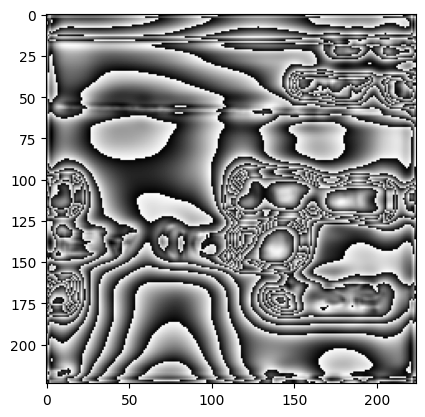

In [36]:
plt.imshow(img_pil,cmap='gray')